<a href="https://colab.research.google.com/github/betr0dalf/TIMO/blob/main/TIMO_NovikovDV_sem2_prac3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Технологии и инструментарий машинного обучения
# Практическая работа № 3
# Выполнил студент группы ИНБО-05-22
# Новиков Денис Владиславович

## Импорт необходимых библиотек

In [ ]:
# Установка дополнительных библиотек (если нужно)
!pip install torch torchvision matplotlib numpy scikit-learn torchcam

# Импорт всех необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
from torchvision.utils import make_grid

# Настройки для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)

## Часть 1: Общий пример (1 пара)
1. Загрузка и исследование данных:
* Загрузите датасет CIFAR-10 или аналогичный из библиотеки
keras.datasets или torchvision.datasets.
* Выполните предварительную обработку данных: нормализация
изображений и преобразование классов в категориальный вид.
2. Создание сверточной нейронной сети:
* Архитектура сети:
* Первый сверточный слой с фильтрами (3x3), активация ReLU.
* Пулинг-слой (2x2).
* Добавьте 2-3 сверточных слоя с последующими пулингами.
* Полносвязный слой с Softmax для классификации.
* Инициализация модели с использованием TensorFlow или PyTorch.
3. Обучение сети:
* Оптимизатор: Adam.
* Функция потерь: кросс-энтропия.
* Обучите сеть на 10-20 эпохах и сохраните результаты.
4. Визуализация:
* Графики изменения потерь и точности на обучающей и тестовой
выборках.
* Визуализация фильтров первого сверточного слоя.

100%|██████████| 170M/170M [00:02<00:00, 77.9MB/s]


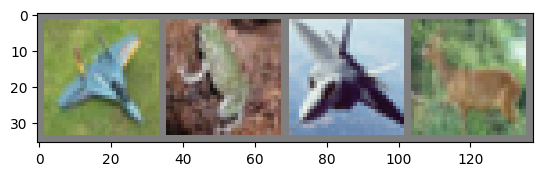

самолет лягушка самолет олень


In [ ]:
# Определение преобразований для данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Загрузка датасета CIFAR-10
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Разделение на обучающую и валидационную выборки
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Создание DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Названия классов CIFAR-10
classes = ('самолет', 'автомобиль', 'птица', 'кот', 'олень',
           'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик')

# Функция для отображения изображений
def imshow(img):
    img = img / 2 + 0.5  # денормализация
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Получение нескольких обучающих изображений
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Показ изображений
imshow(make_grid(images[:4]))
# Вывод соответствующих меток
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Инициализация модели
model = CNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Вывод архитектуры модели
print(model)

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_acc.append(train_accuracy)

        # Валидация
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_acc.append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_acc, val_acc

# Обучение модели
train_losses, val_losses, train_acc, val_acc = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs=20)

Epoch 1/20, Train Loss: 1.6448, Train Acc: 39.23%, Val Loss: 1.3246, Val Acc: 51.52%
Epoch 2/20, Train Loss: 1.3078, Train Acc: 52.80%, Val Loss: 1.1407, Val Acc: 59.46%
Epoch 3/20, Train Loss: 1.1423, Train Acc: 59.21%, Val Loss: 1.0041, Val Acc: 64.44%
Epoch 4/20, Train Loss: 1.0246, Train Acc: 63.53%, Val Loss: 0.8921, Val Acc: 68.64%
Epoch 5/20, Train Loss: 0.9343, Train Acc: 67.34%, Val Loss: 0.8530, Val Acc: 69.08%
Epoch 6/20, Train Loss: 0.8590, Train Acc: 70.08%, Val Loss: 0.8057, Val Acc: 71.45%
Epoch 7/20, Train Loss: 0.8042, Train Acc: 71.95%, Val Loss: 0.7530, Val Acc: 73.00%
Epoch 8/20, Train Loss: 0.7431, Train Acc: 74.03%, Val Loss: 0.7738, Val Acc: 72.79%
Epoch 9/20, Train Loss: 0.6939, Train Acc: 75.58%, Val Loss: 0.7654, Val Acc: 73.11%
Epoch 10/20, Train Loss: 0.6556, Train Acc: 76.86%, Val Loss: 0.7706, Val Acc: 73.60%
Epoch 11/20, Train Loss: 0.6169, Train Acc: 78.14%, Val Loss: 0.7546, Val Acc: 74.09%
Epoch 12/20, Train Loss: 0.5769, Train Acc: 79.54%, Val Loss: 0

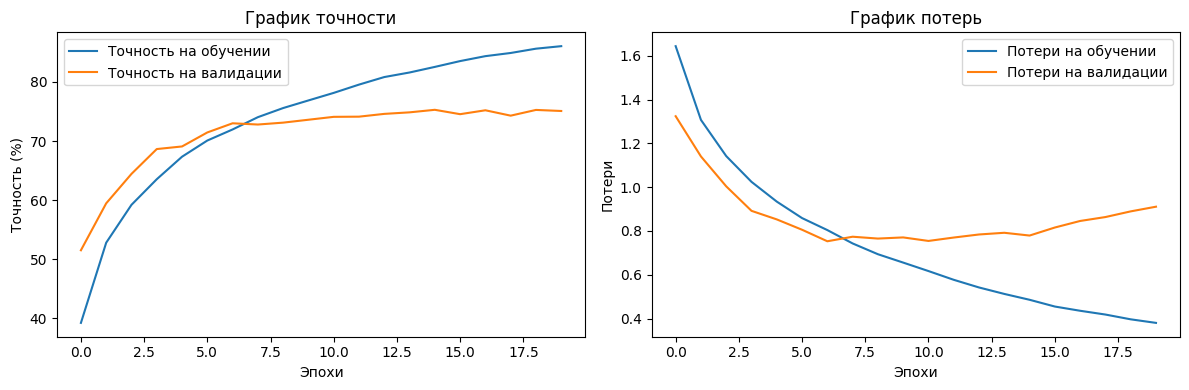

Точность на тестовых данных: 74.16%
Потери на тестовых данных: 0.9574


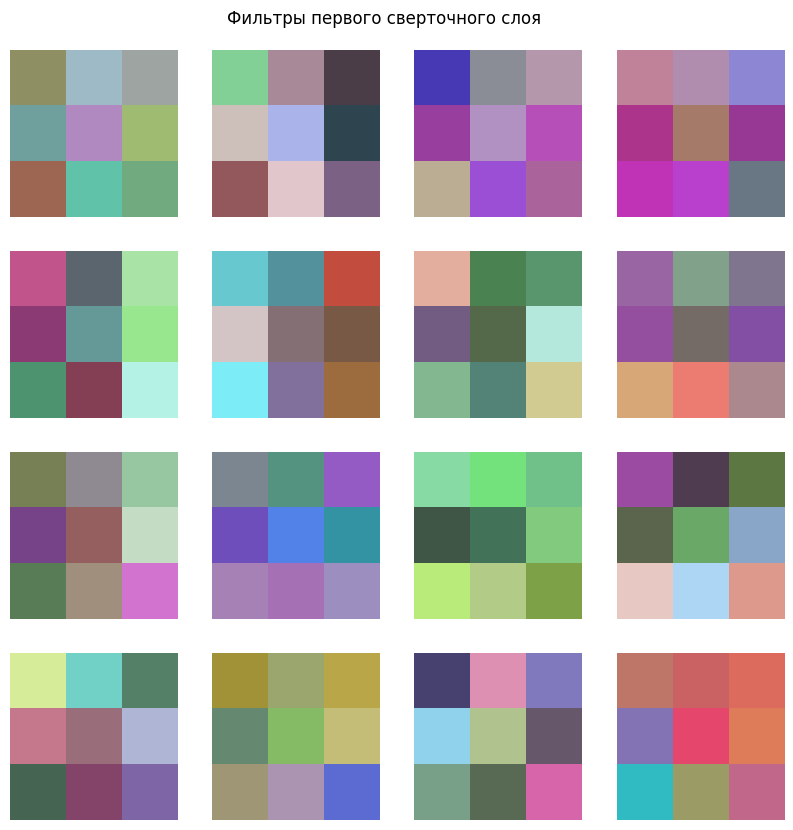

In [ ]:
# Функция для построения графиков обучения
def plot_training_history(train_losses, val_losses, train_acc, val_acc):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # График точности
    ax1.plot(train_acc, label='Точность на обучении')
    ax1.plot(val_acc, label='Точность на валидации')
    ax1.set_title('График точности')
    ax1.set_xlabel('Эпохи')
    ax1.set_ylabel('Точность (%)')
    ax1.legend()

    # График потерь
    ax2.plot(train_losses, label='Потери на обучении')
    ax2.plot(val_losses, label='Потери на валидации')
    ax2.set_title('График потерь')
    ax2.set_xlabel('Эпохи')
    ax2.set_ylabel('Потери')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Визуализация графиков обучения
plot_training_history(train_losses, val_losses, train_acc, val_acc)

# Оценка модели на тестовых данных
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader)
    print(f'Точность на тестовых данных: {test_accuracy:.2f}%')
    print(f'Потери на тестовых данных: {avg_test_loss:.4f}')
    return test_accuracy, avg_test_loss

test_accuracy, test_loss = evaluate_model(model, test_loader)

# Визуализация фильтров первого сверточного слоя
def visualize_filters(model):
    weights = model.conv1.weight.data.cpu().numpy()
    weights = (weights - weights.min()) / (weights.max() - weights.min())

    plt.figure(figsize=(10, 10))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.transpose(weights[i], (1, 2, 0)))
        plt.axis('off')
    plt.suptitle('Фильтры первого сверточного слоя', y=0.92)
    plt.show()

visualize_filters(model)

## Часть 2: Индивидуальные задания (2 пара)
1. Параметры сети:
* Каждому студенту предоставляется уникальный набор параметров:
* Количество фильтров (32, 64, 128).
* Размеры фильтров (3x3, 5x5).
* Функции активации (ReLU, Sigmoid).
* Постройте сверточную сеть с предложенными параметрами и
обучите её на заданном датасете.
2. Анализ моделей:
* Сравните результаты обучения при изменении параметров сети
(фильтры, размер свёрток).
* Проанализируйте, как параметры влияют на переобучение и
точность на тестовой выборке.


Обучение модели: 32 фильтра, 3x3, ReLU
Epoch 1/15, Train Loss: 1.6397, Train Acc: 40.01%, Val Loss: 1.3076, Val Acc: 53.44%
Epoch 2/15, Train Loss: 1.3627, Train Acc: 50.54%, Val Loss: 1.1603, Val Acc: 58.71%
Epoch 3/15, Train Loss: 1.2621, Train Acc: 54.76%, Val Loss: 1.1208, Val Acc: 61.00%
Epoch 4/15, Train Loss: 1.1868, Train Acc: 57.36%, Val Loss: 1.0708, Val Acc: 61.77%
Epoch 5/15, Train Loss: 1.1418, Train Acc: 58.60%, Val Loss: 1.0330, Val Acc: 63.54%
Epoch 6/15, Train Loss: 1.0830, Train Acc: 60.88%, Val Loss: 1.0168, Val Acc: 63.96%
Epoch 7/15, Train Loss: 1.0546, Train Acc: 61.98%, Val Loss: 1.0180, Val Acc: 63.85%
Epoch 8/15, Train Loss: 1.0262, Train Acc: 62.88%, Val Loss: 1.0231, Val Acc: 63.73%
Epoch 9/15, Train Loss: 0.9946, Train Acc: 63.88%, Val Loss: 0.9898, Val Acc: 64.93%
Epoch 10/15, Train Loss: 0.9707, Train Acc: 64.68%, Val Loss: 0.9853, Val Acc: 65.06%
Epoch 11/15, Train Loss: 0.9386, Train Acc: 65.93%, Val Loss: 0.9804, Val Acc: 65.41%
Epoch 12/15, Train Loss

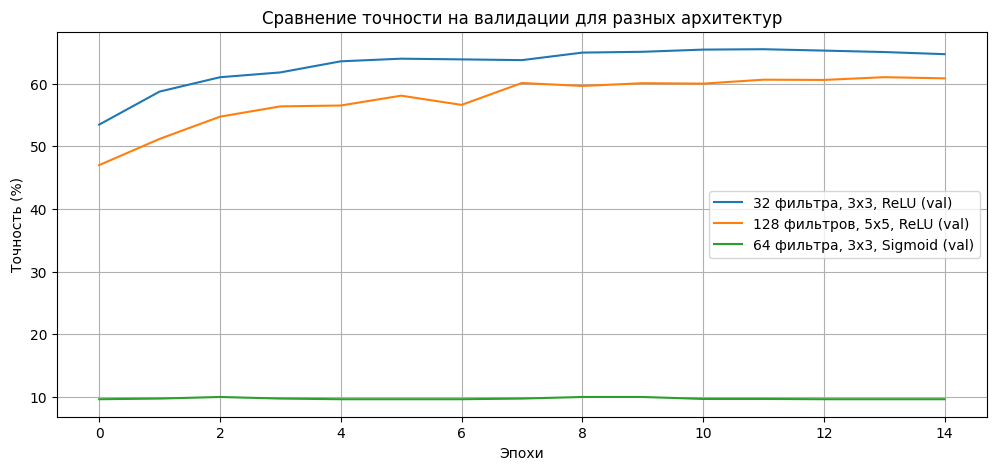


Сравнительная таблица характеристик моделей:
Параметры модели                    Train Accuracy  Test Accuracy   Loss (val)      Переобучение   
32 фильтра, 3x3, ReLU               68.76           65.47           1.0130          да             
128 фильтров, 5x5, ReLU             48.06           61.12           1.1435          нет            
64 фильтра, 3x3, Sigmoid            9.91            10.00           2.3027          да             


In [ ]:
class CNNVariation1(nn.Module):
    """32 фильтра, 3x3, ReLU"""
    def __init__(self):
        super(CNNVariation1, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

class CNNVariation2(nn.Module):
    """128 фильтров, 5x5, ReLU"""
    def __init__(self):
        super(CNNVariation2, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

class CNNVariation3(nn.Module):
    """64 фильтра, 3x3, Sigmoid"""
    def __init__(self):
        super(CNNVariation3, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.sigmoid(self.conv1(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


def train_and_evaluate(model_class, name, train_loader, val_loader, test_loader, epochs=15):
    print(f"\nОбучение модели: {name}")
    model = model_class().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses, train_acc, val_acc = train_model(
        model, train_loader, val_loader, criterion, optimizer, epochs)

    test_accuracy, test_loss = evaluate_model(model, test_loader)

    return {
        'name': name,
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'test_accuracy': test_accuracy,
        'test_loss': test_loss
    }

# Обучение и оценка различных архитектур
results = []
results.append(train_and_evaluate(CNNVariation1, "32 фильтра, 3x3, ReLU",
                                  train_loader, val_loader, test_loader))
results.append(train_and_evaluate(CNNVariation2, "128 фильтров, 5x5, ReLU",
                                  train_loader, val_loader, test_loader))
results.append(train_and_evaluate(CNNVariation3, "64 фильтра, 3x3, Sigmoid",
                                  train_loader, val_loader, test_loader))

# Визуализация сравнения моделей
plt.figure(figsize=(12, 5))
for res in results:
    plt.plot(res['val_acc'], label=f"{res['name']} (val)")
plt.title('Сравнение точности на валидации для разных архитектур')
plt.xlabel('Эпохи')
plt.ylabel('Точность (%)')
plt.legend()
plt.grid(True)
plt.show()

# Таблица результатов в нужном формате
print("\nСравнительная таблица характеристик моделей:")
print("{:<35} {:<15} {:<15} {:<15} {:<15}".format(
    "Параметры модели", "Train Accuracy", "Test Accuracy", "Loss (val)", "Переобучение"
))
for res in results:
    train_last = res['train_acc'][-1]
    val_last = res['val_acc'][-1]
    test_acc = res['test_accuracy']
    overfitting = "да" if train_last - val_last > 0.05 else "нет"
    print("{:<35} {:<15.2f} {:<15.2f} {:<15.4f} {:<15}".format(
        res['name'], train_last, test_acc, res['val_losses'][-1], overfitting
    ))


## Часть 3: Защита и интерпретация результатов (3 пара)
1. Защитите свою модель, представив основные результаты:
* Итоговые метрики (точность, F1-мера).
* Влияние архитектурных параметров на обучение и переобучение.
2. Используйте инструменты интерпретации (например, Grad-CAM) для
визуализации важных областей изображений, на которые обращала внимание сеть.

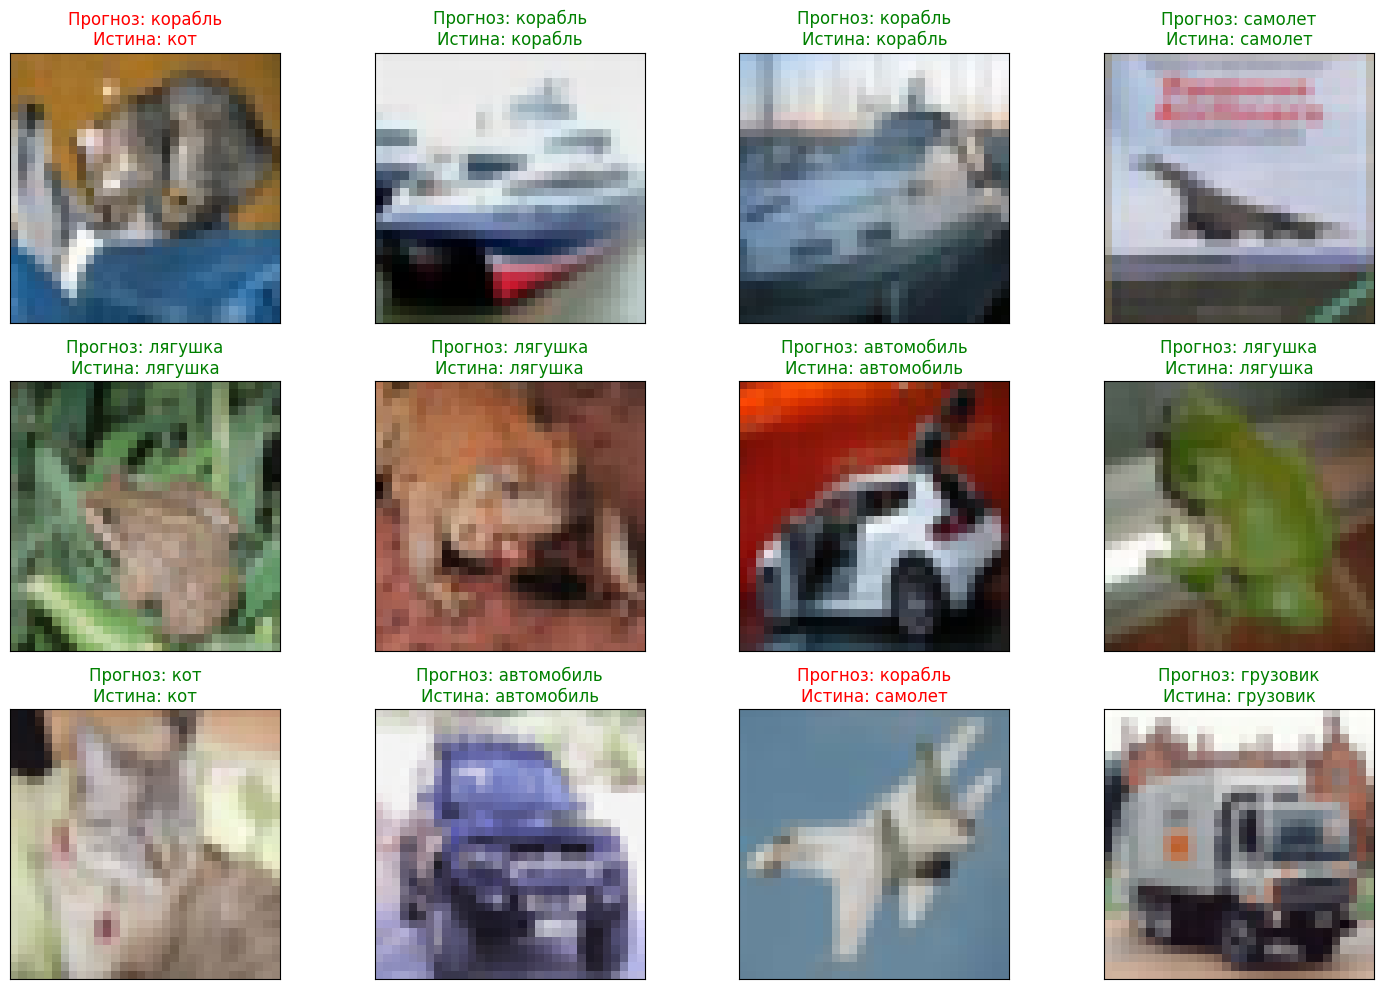

In [ ]:
def visualize_predictions(model, test_loader, class_names, num_images=12):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images[:num_images])
        _, preds = torch.max(outputs, 1)

    images = images.cpu()
    fig = plt.figure(figsize=(15, 10))
    for i in range(num_images):
        ax = fig.add_subplot(3, 4, i+1, xticks=[], yticks=[])
        img = images[i] / 2 + 0.5  # денормализация
        plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))

        color = 'green' if preds[i] == labels[i] else 'red'
        ax.set_title(f"Прогноз: {class_names[preds[i]]}\nИстина: {class_names[labels[i]]}",
                     color=color)
    plt.tight_layout()
    plt.show()

# Визуализация предсказаний лучшей модели
best_model = results[1]['model']  # (128 фильтров, 5x5, ReLU)
visualize_predictions(best_model, test_loader, classes)

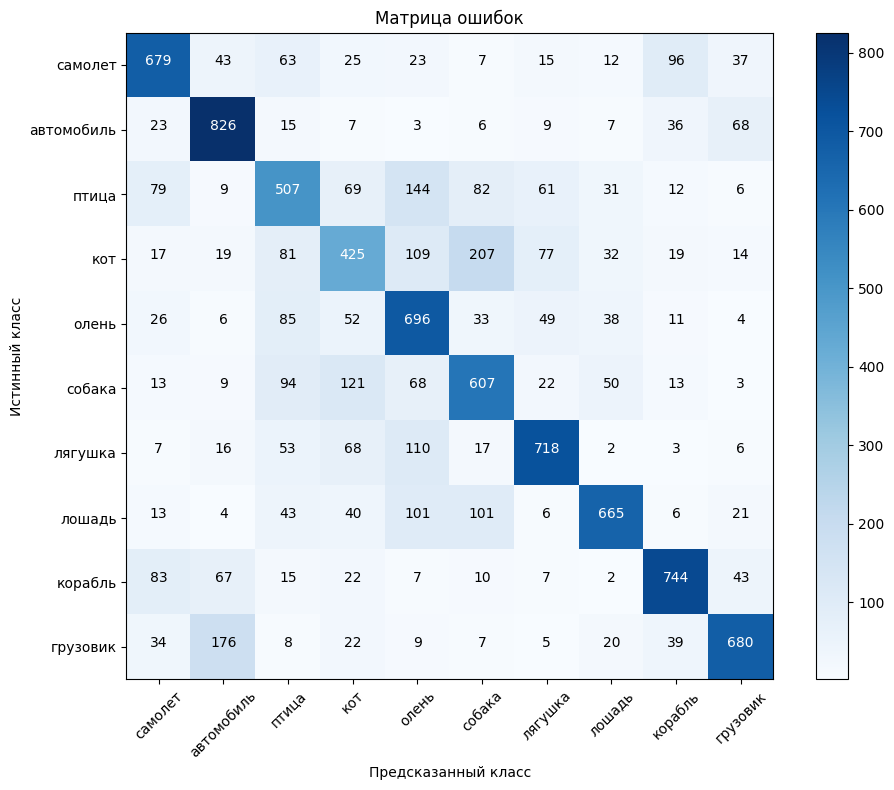


Отчет о классификации:
              precision    recall  f1-score   support

     самолет       0.70      0.68      0.69      1000
  автомобиль       0.70      0.83      0.76      1000
       птица       0.53      0.51      0.52      1000
         кот       0.50      0.42      0.46      1000
       олень       0.55      0.70      0.61      1000
      собака       0.56      0.61      0.58      1000
     лягушка       0.74      0.72      0.73      1000
      лошадь       0.77      0.67      0.72      1000
     корабль       0.76      0.74      0.75      1000
    грузовик       0.77      0.68      0.72      1000

    accuracy                           0.65     10000
   macro avg       0.66      0.65      0.65     10000
weighted avg       0.66      0.65      0.65     10000



In [ ]:
def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Матрица ошибок')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

    print("\nОтчет о классификации:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

plot_confusion_matrix(best_model, test_loader, classes)

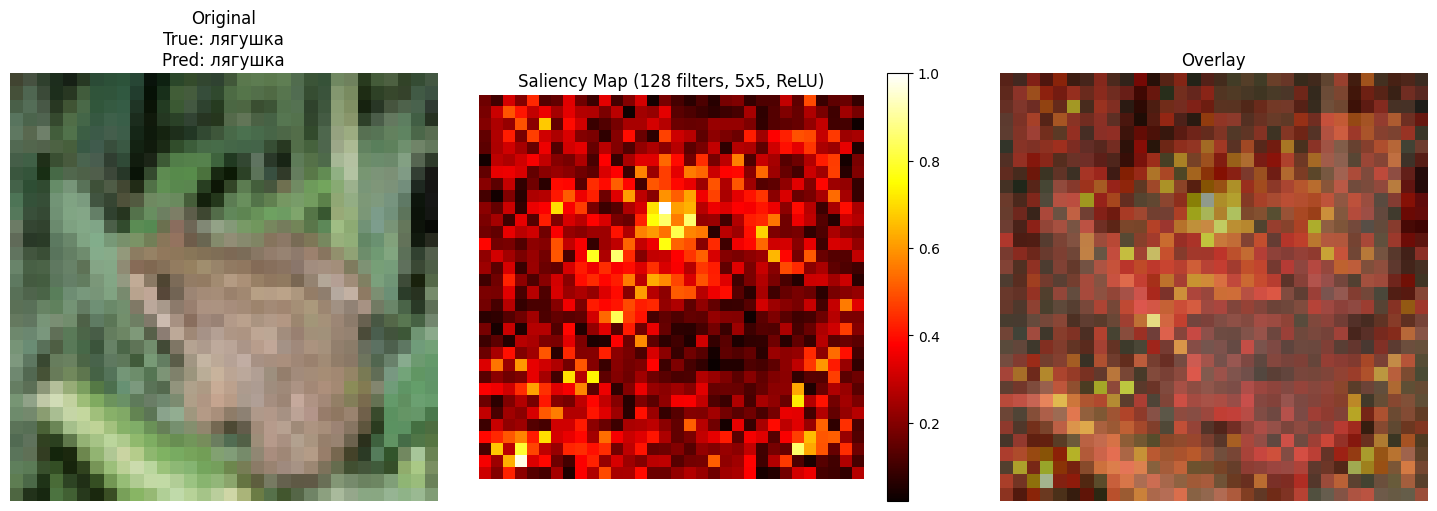

In [ ]:
# Функция для вычисления Saliency Map
def compute_saliency(model, image, target_class):
    model.eval()
    image = image.unsqueeze(0).to(device)
    image.requires_grad_()

    output = model(image)
    score = output[0, target_class]
    score.backward()

    saliency = image.grad.data.abs().squeeze(0)
    saliency = saliency / saliency.max()  # Нормализация

    return saliency.cpu().numpy()

# Получаем модель "128 фильтров, 5x5, ReLU" (CNNVariation2)
best_model = None
for res in results:
    if "128 фильтров, 5x5, ReLU" in res['name']:
        best_model = res['model']
        break

if best_model is not None:
    # Берем одно тестовое изображение
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    image = images[4]
    true_label = labels[4].item()

    # Получаем предсказание модели
    best_model.eval()
    with torch.no_grad():
        output = best_model(image.unsqueeze(0).to(device))
    predicted_class = output.argmax().item()

    # Вычисляем Saliency Map
    saliency = compute_saliency(best_model, image, predicted_class)

    # Визуализация
    plt.figure(figsize=(15, 5))

    # 1. Оригинальное изображение
    plt.subplot(1, 3, 1)
    img = image / 2 + 0.5  # Денормализация
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.title(f'Original\nTrue: {classes[true_label]}\nPred: {classes[predicted_class]}')
    plt.axis('off')

    # 2. Saliency Map (максимум по каналам)
    plt.subplot(1, 3, 2)
    saliency_combined = np.max(saliency, axis=0)
    plt.imshow(saliency_combined, cmap='hot')
    plt.title('Saliency Map (128 filters, 5x5, ReLU)')
    plt.colorbar()
    plt.axis('off')

    # 3. Наложение
    plt.subplot(1, 3, 3)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.imshow(saliency_combined, cmap='hot', alpha=0.5)
    plt.title('Overlay')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
